# Latent Dirichlet Allocation

** Blei, Ng & Jordan (2003) **

** NB: The following explains the ideas of LDA model as presented in BNJ03. The experiment on datasets makes use of off-the-shelf package (cf. https://radimrehurek.com/gensim/models/ldamodel.html, which uses *Online Variational Bayes Algorithm for optimization* (Hoffman et al. 2010), for a tutorial, cf. https://rstudio-pubs-static.s3.amazonaws.com/79360_850b2a69980c4488b1db95987a24867a.html) to avoid unncessary digression into the details of optimization. **

In [1]:
from IPython.display import display, Image

### A. Generative Story

** Model ** (cf. BNJ03:997,fig.1)

**NB:** The following is my own interpretation of their model. Comments and critiques are welcome.

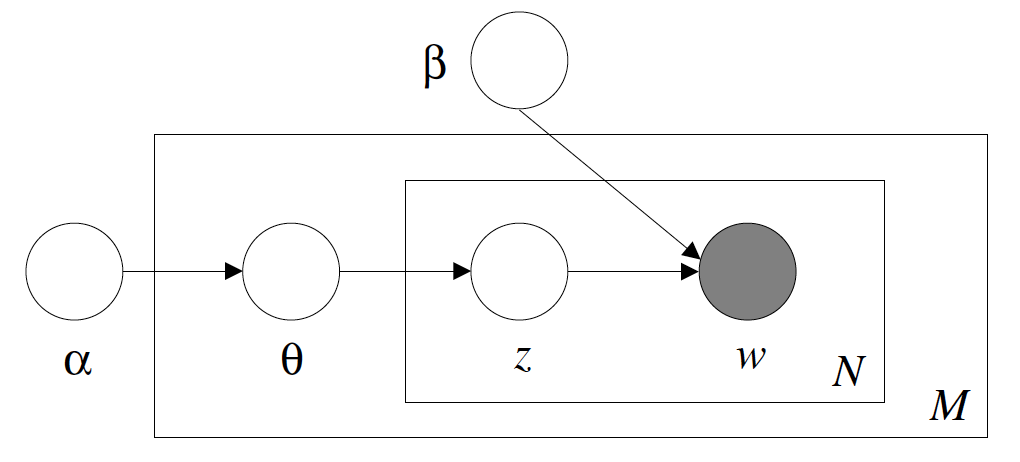

In [3]:
display(Image(filename='/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/BASIC_TOPICS/LDA/FIGS/BNJ03_model.png',width='40%'))

** Notation ** (cf. BNJ03:997)

* $\alpha$: Prior *"Relative Weights"* of topics, sampled once per corpus.
* $\beta$: Prior probability distributions over words over topics, sampled once per corpus.
* $\theta$: Distribution over probabilities of topics in a document, sampled once per document.
* $z$: The topic of a word, sampled once per word slot.
* $w$: A word, sampled once per word slot.
* $N$: The number of words in a document.
* $M$: The number of documents in a corpus.

** Distributions ** (cf. BNJ03:995-6)

* Priors
    * $\alpha_1 = ... = \alpha_j = ... = \alpha_k$ (given that the number of topics is $k$)
    * $\beta_{z_j,1} = ... = \beta_{z_j,i} = ... = \beta_{z_j,V}$ (given that the size of the vocab is $V$)


* Sampled Distributions
    * $\theta \sim Dir(\alpha)$ (i.e. Symmetrical Dirichlet)
    * $z \sim Multinomial(\theta)$
    * $w \sim Multinomial(\beta_{z_j})$ (NB: in $\beta$, each topic $z_j$ has a distribution over words)

** Generative Story ** (cf. BNJ03:998)

* The "Story"
    * In starting to write a document, we have the following prior knowledge:
        * What topic we'd like to write on (this determines the $\alpha$ relative weights).
        * For a particular topic $z_j$, what words are more likely (this determines the $\beta_{z_j}$).
    * In writing the document, we ...
        * First pick a topic for the document according to topic relative weights distribution.
        * Repeatedly picking words according to word frequency distribution of the topic, until the completion of the document.
    

* Generation Procedure
    * Step 1: For each corpus, ...
        * $\alpha = \{\alpha_j\}, j = 1,...,k$ is set.
        * $\beta = \{\beta_{z_j}\}, j = 1,...,k$ is set.

    * Step 2: For each document, ...
        * Generate a $\theta_d$ for document $d$, where $\theta_d \sim Dir(\alpha)$.

    * Step 3: For each word slot, ...
        * Generate a topic $z_j$, where $z_j \sim Multinomial(\theta_d)$.
        * Generate a word $w_i$, where $w_i \sim Multinomial(\beta_{z_j})$

** Geometric Interpretation of the Generation Process ** (cf. BNJ03:1002,fig.4)

* The *Topic Simplex* is generated from the prior $\alpha$ using $Dir(\alpha)$.
* The *Word Simplex* is generated from the prior $\beta_{z_j}$ using $Dir(\beta_{z_j})$.

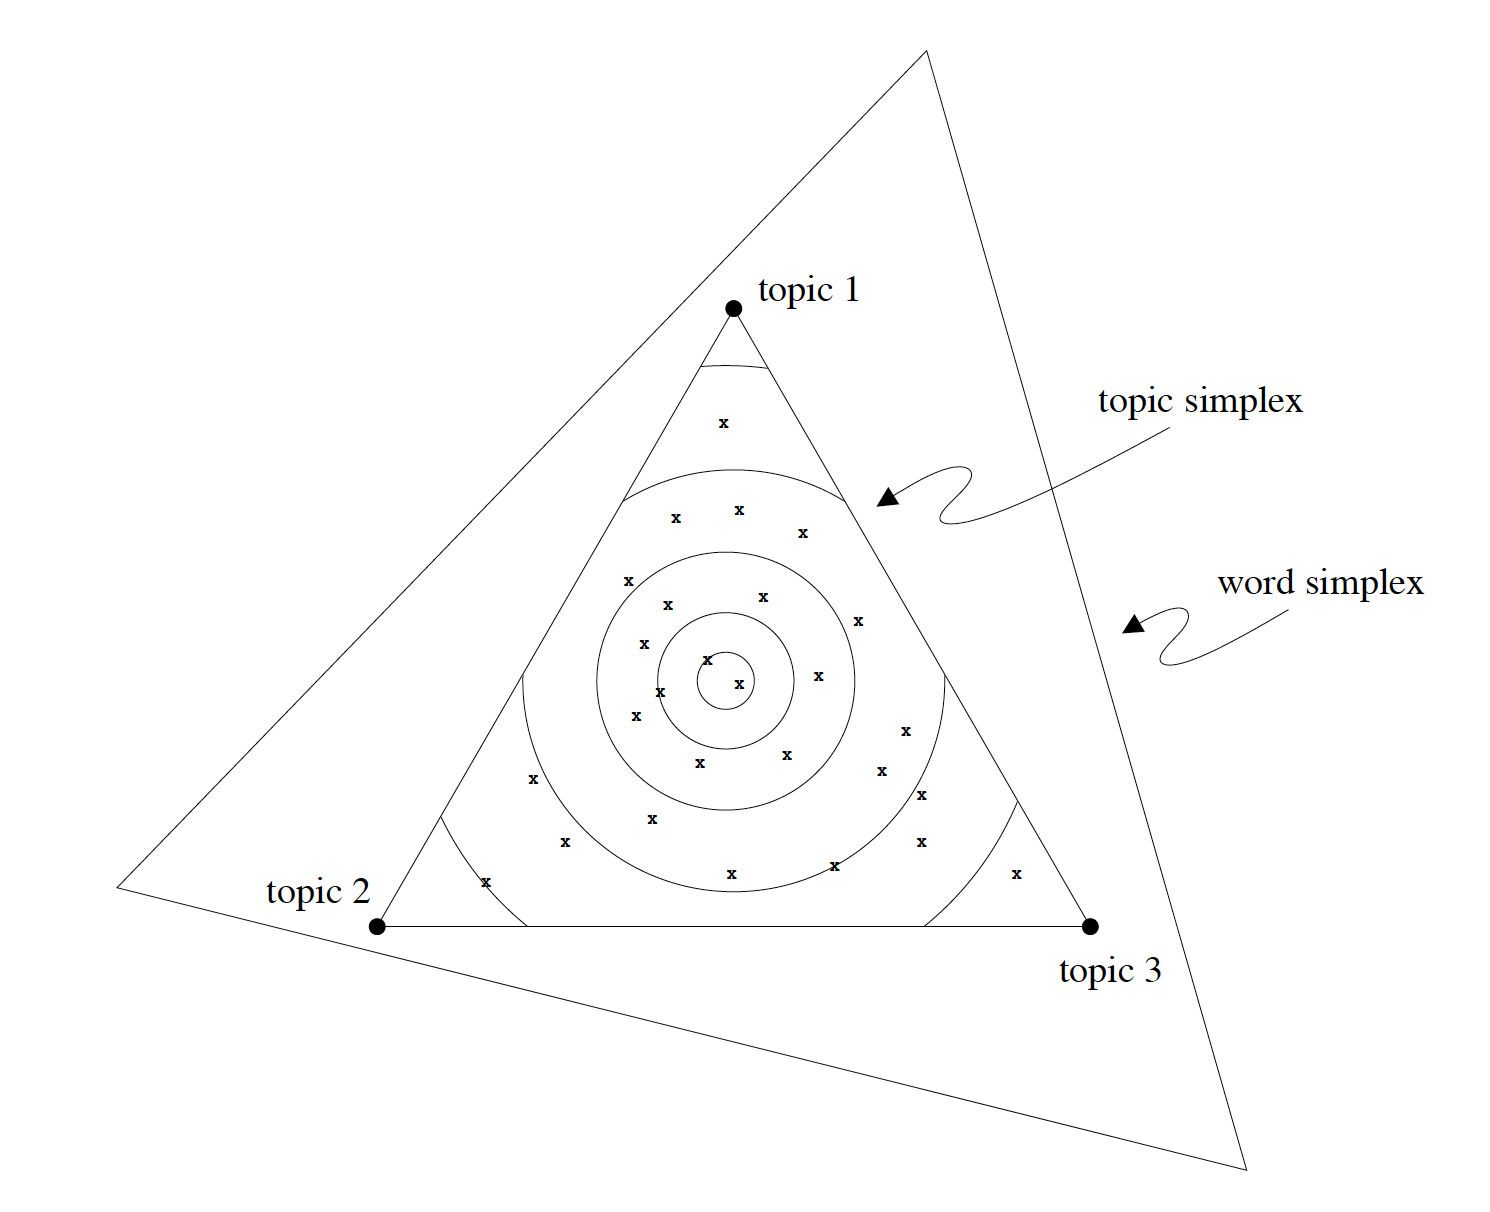

In [57]:
display(Image(filename='/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/BASIC_TOPICS/LDA/FIGS/BNJ03_geometric_interpretation.png',width='40%'))

** Example **

* Priors
    * 2 topics: {government, romance}
    * 6 words: {obama, govern, administration, love, kiss, date}
    * $\alpha = 1$ (i.e. equal *relative weight* for all topics)
    * $\beta_{government} = [.3,.3,.3,.03,.03,.04]$
    * $\beta_{romance} = [.03,.03,.04,.3,.3,.3]$


* Corpus to be generated
    * 10 documents
    * 50 words per document.

In [49]:
import numpy as np

In [29]:
topics = ['government','romance']
words = ['obama','govern','administration','love','kiss','date']
alpha = 1
beta = {'government':[.3,.3,.3,.03,.03,.04],
        'romance':[.03,.03,.04,.3,.3,.3]}

In [30]:
def corpus_generator(alpha, beta, topics, words, num_docs=10, num_words=50):
    corpus = []
    for d in xrange(num_docs):
        doc = []
        theta = np.random.dirichlet(alpha=[alpha]*len(topics))
        for i in xrange(num_words):
            z_j = topics[np.argmax(np.random.multinomial(1, theta))]
                #   |       |                  |
                # string   idx          [..., 1, ...]   
            w_i = words[np.argmax(np.random.multinomial(1, beta[z_j]))]
            doc.append((w_i,z_j))
        corpus.append(doc)
    return corpus

In [32]:
corpus = corpus_generator(alpha, beta, topics, words)

In [50]:
from copy import deepcopy
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [51]:
def summarize(documents, k=5, figsize=(10,4)):
    # keep top-k frequent words
    top_k_vocab = lambda doc: map(lambda (w,t): w, 
                                      Counter([w for w,t in doc]).most_common(k))
    get_top_k = lambda doc,vocab: [(w,t) for w,t in doc if w in vocab]
    documents = deepcopy(documents) # avoid modifying the original.
    for i,document in enumerate(documents):
        vocab = top_k_vocab(document)
        documents[i] = get_top_k(document,vocab)
    # count words & topics
    word_counts = lambda d: Counter([w for w,t in d])
    topic_counts = lambda d: Counter([t for w,t in d]) 
    num_docs = len(documents)
    word_dists, topic_dists = [], []
    for document in documents:
        word_dists.append(word_counts(document))
        topic_dists.append(topic_counts(document))
    # plotting
    print "WORD & TOPIC COUNTS"
    ylim = max(len(d) for d in documents)
    width = .7
    plt.subplots(figsize=figsize)
    for i in xrange(len(documents)*2):
        plt.subplot(2,len(documents),i+1)
        plt.ylim(0,ylim)
        if i < len(documents):
            plt.bar(np.arange(len(word_dists[i])),word_dists[i].values(),
                    width=width,align='center',color='blue')
            plt.xticks(np.arange(len(word_dists[i]))+width*.05, 
                        word_dists[i].keys())
        else:
            plt.bar(np.arange(len(topic_dists[i-len(documents)])),
                    topic_dists[i-len(documents)].values(),
                    width=width,align='center',color='grey')
            plt.xticks(np.arange(len(topic_dists[i-len(documents)]))+width*.005, 
                        topic_dists[i-len(documents)].keys()) 
    plt.show()

** Comments **

* In 'government' or 'romance' dominant documents, 'government'/'romance'-likely words appear more often.

WORD & TOPIC COUNTS


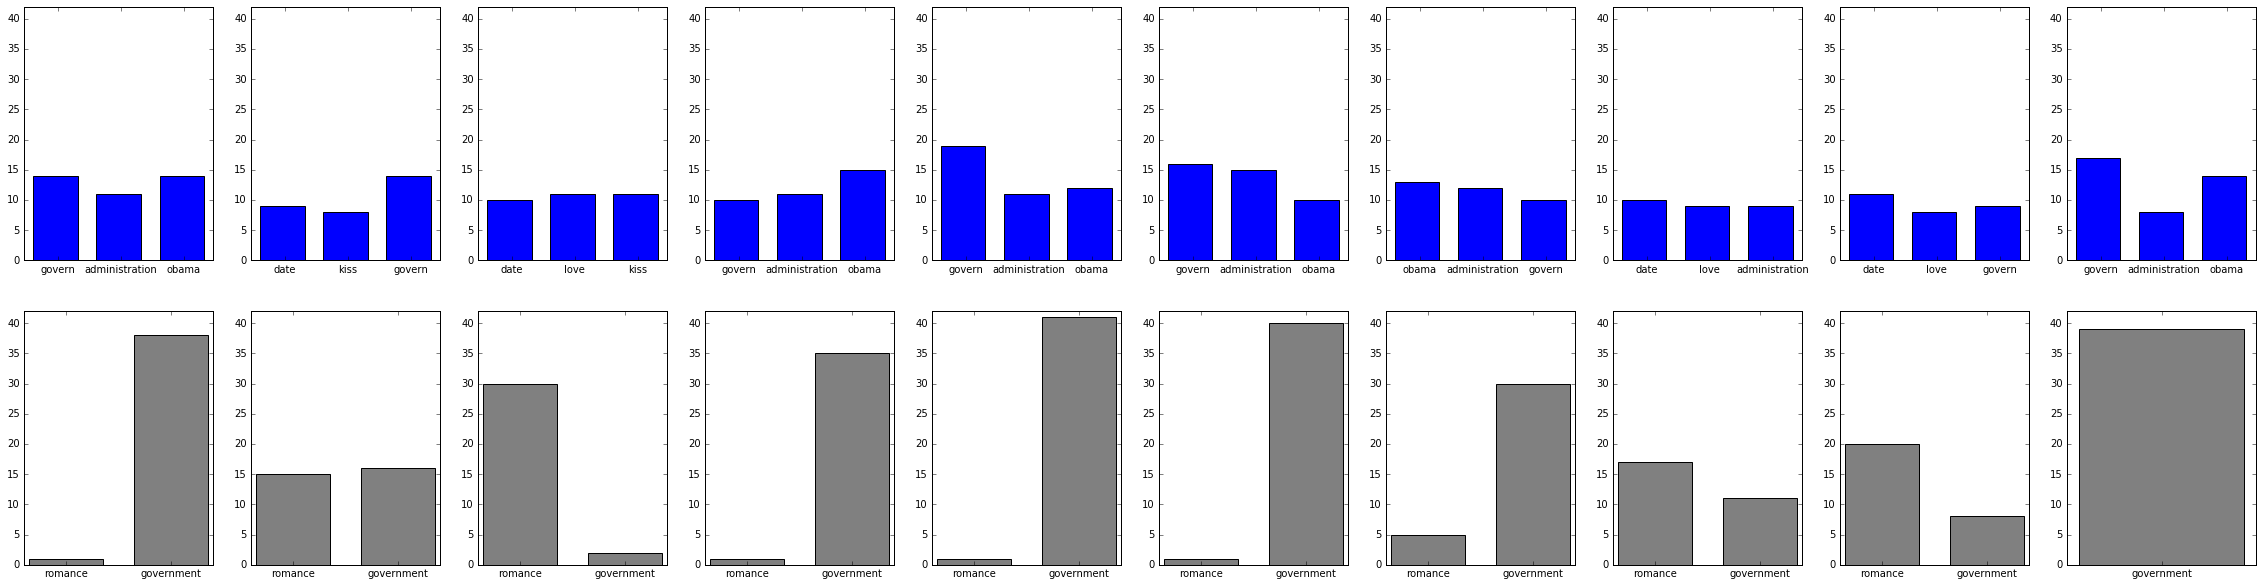

In [56]:
summarize(corpus, k=3, figsize=(40,10))

### B. Parameter Learning: $\alpha$ & $\beta$

** NB: For the full description of the optimization algorithm, cf. BNJ03:Appendix A. **

** Optimization Goal **

* Given a document $\mathbf{w}$, find the $\alpha$ and $\beta$ that maximize the log-likelihood of the document (as computed using the model).
* $\ell(\alpha,\beta) = logp(\mathbf{w}|\alpha,\beta)$.

** Intractability of Direct Computation **

* $p(\mathbf{w}|\alpha,\beta)$ is intractable due to the coupling of parameters $\theta$ and $\beta$ (cf. BNJ03:1002). Put it more simply, using $\beta_{z_j}$ to generate a word, we need first sample the topic $z_j$ from $\theta_d$ (i.e. the distribution sampled from $Dir(\alpha)$ for document $d$).
* $p(\mathbf{w}|\alpha,\beta) = \frac{\Gamma(\sum_i\alpha_i)}{\prod_i\Gamma(\alpha_i)}\int\left(\prod_{i=1}^{k}\theta_i^{\alpha_i-1}\right)\left(\prod_{n=1}^N\sum_{i=1}^k\prod_{j=1}^V(\theta_i\beta_{ij})^{w_n^j}\right)d\theta$.

** Solution: Approximation by *Variational Inference* **

* Find the lower bound of $logp(\mathbf{w}|\alpha,\beta)$, denoted $L(\gamma,\phi;\alpha,\beta)$, then maximize this lower bound while minimizing the *KL-Divergence* between the lower bound distribution and the true distribution. Finally update $\alpha$ and $\beta$.
* $logp(\mathbf{w}|\alpha,\beta) = L(\gamma,\phi;\alpha,\beta) + D(q(\theta,\mathbf{z}|\gamma,\phi)||p(\theta,\mathbf{z}||\mathbf{w},\alpha,\beta))$.


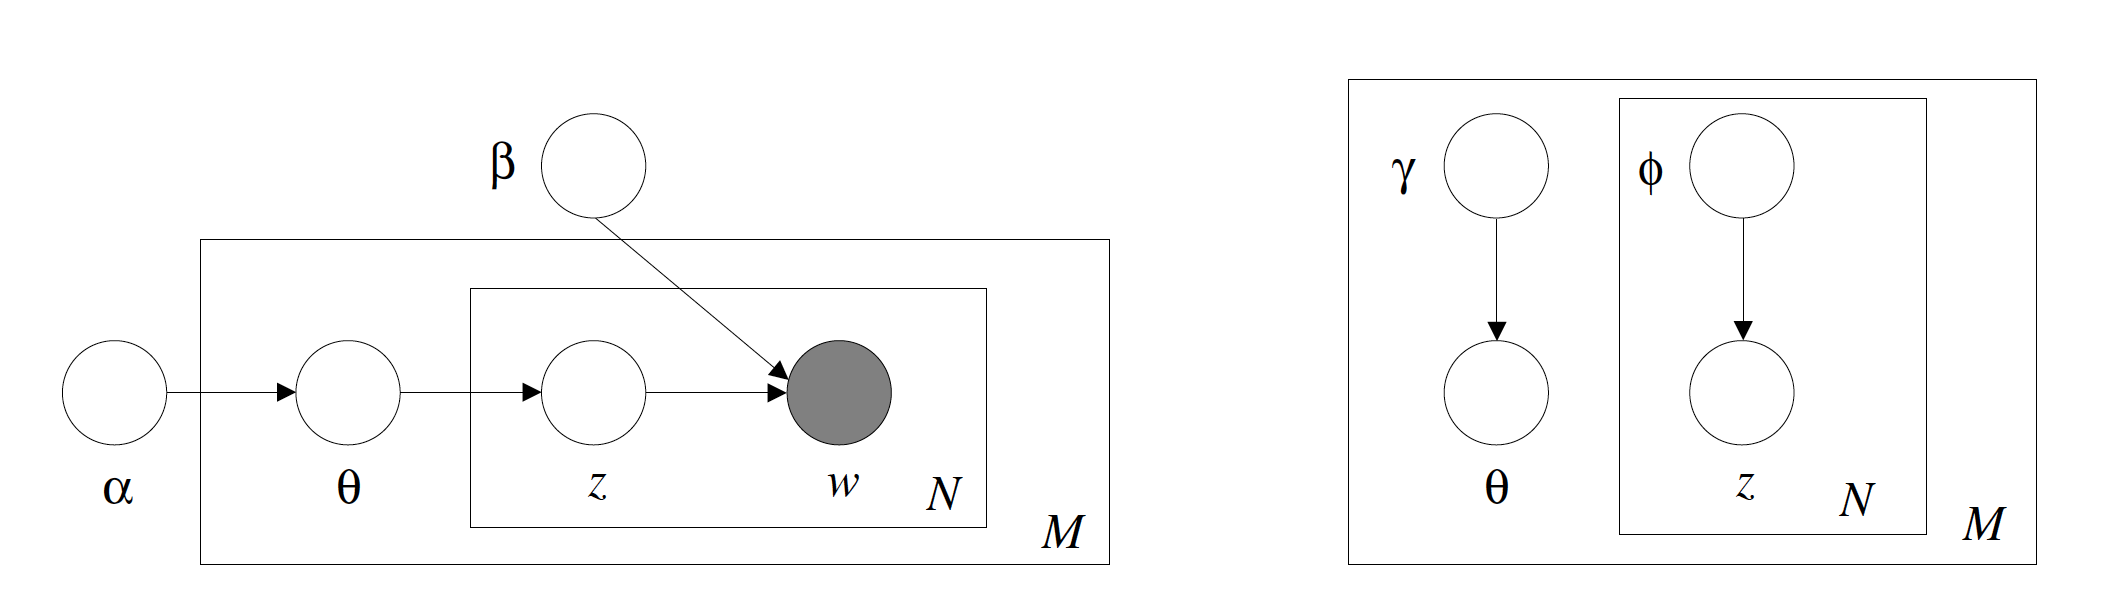

In [61]:
display(Image(filename='/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/BASIC_TOPICS/LDA/FIGS/BNJ03_variational_inference.png',width='60%'))

### C. Experiments

** NB: Same setup as in my SG04 implementation. **

* Documents: 3 documents (10000 words per document) with the following topic mixing:
    * Single-Topic Documents: 0, 1.
    * Bi-Topic Documents: maxent mixing.
* Confounder: Give the model 3 topic labels, and see if it knows there are actually only 2.

** Comments **

* The model runs lightning fast and gives accurate prediction even in the presence of a confounder.

In [77]:
import cPickle

In [109]:
from gensim import corpora
from gensim.models.ldamodel import LdaModel

In [79]:
# data_folder = '/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/BASIC_TOPICS/LDA/DATA/'
# cPickle.dump(documents, open(data_folder+'brown_government_hobbies.p', 'wb')) 
# documents = cPickle.load(open(data_folder+'brown_government_hobbies.p', 'rb'))

In [252]:
class TopicModel:
    
    def __init__(self, documents, num_topics=3, num_iters=3):
        dic = corpora.Dictionary(documents)
        documents = [dic.doc2bow(document) for document in documents]
        self.documents = documents
        self.lda = LdaModel(documents, num_topics=num_topics, id2word=dic, passes=num_iters)
    
    def summarize(self, num_topics=3, num_words=5):
        freq_stats = self.lda.print_topics(num_topics=num_topics, num_words=num_words)
        print "Statistics"
        print 
        for i,document in enumerate(self.documents):
            print "Most %d-Frequent Words in Topic %d:" % (num_words,freq_stats[i][0])
            print freq_stats[i][1]
            print "Topic-Distribution:"
            print lda.get_document_topics(document)
            print

In [253]:
TopicModel(documents).summarize()

Statistics

Most 5-Frequent Words in Topic 0:
0.004*use + 0.004*one + 0.004*year + 0.003*state + 0.003*make
Topic-Distribution:
[(2, 0.9999284078357662)]

Most 5-Frequent Words in Topic 1:
0.008*state + 0.007*year + 0.005*use + 0.005*one + 0.005*develop
Topic-Distribution:
[(1, 0.99992683441930597)]

Most 5-Frequent Words in Topic 2:
0.007*use + 0.006*one + 0.004*work + 0.004*time + 0.004*make
Topic-Distribution:
[(1, 0.49226468121888323), (2, 0.50770139160880823)]

